# START CASEY'S NOTEBOOK

# <center> Project 2 - Classification of Wind Turbine Alarms and Power Performance</center>

## <center> MSDS 7331 Data Mining - Section 401 </center> 
### <center> Team:  Sarah Fite, Sheri Loftin, Casey Martinez, Kyle Thomas </center>



# Imports and Data

For this project, we continue to examine data provided by Siemens, the wind turbine manufacturer, and Pattern Energy, the owner/operator (Casey Martinez's employer).  For this project we analyze this dataset using both Logistics Regression and Support Vector Machines (SVM).

The background of this data and the business understanding behind it can be found as part of Project 1 at: https://github.com/CaseyRMartinez/DataMiningProject1/blob/master/DataMiningProject1_V5.ipynb

In [1]:
import pandas as pd
import numpy as np
import os
# import matplotlib.pyplot as plt
import warnings
import sklearn
# import seaborn as sns
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn import metrics as mt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
from sklearn import svm
from sklearn import tree
import matplotlib.pyplot as plt
# import pydotplus as plt
import six
# from sklearn.tree import export_graphviz

To start, we will first look at the alarm data and one quarter worth of wind farm supervisory control and data acquisition (SCADA) system data.  This SCADA data is specifically used for performance monitoring of large utility-scale wind turbines.

In [2]:
path = "/home/kyle/Documents/thomaskh522@gmail.com/SMU/DataMining/Classificaiton2/"
scada =  pd.read_csv(path + "SCADAcombined2017_T014.csv")
alarms_desc = pd.read_csv(path + "Siemens_Fault_Code_Descriptions.csv")
print("DF scada is: ", scada.shape)
# scada.head()

scada.dropna(thresh=10000,axis=1,inplace=True)

colsdrop = ['StationId', 'CommunicationId', 'NeighbourId',
           'NeighbourIdTwo', 'XPos', 'YPos', 'wtc_ActPower_min',
           'wtc_ActPower_max', 'wtc_ActPower_stddev',
           'wtc_AmpPhR_min', 'wtc_AmpPhR_max', 'wtc_AmpPhR_mean',
           'wtc_AmpPhR_stddev', 'wtc_AmpPhS_min', 'wtc_AmpPhS_max',
           'wtc_AmpPhS_mean', 'wtc_AmpPhS_stddev', 'wtc_AmpPhT_min',
           'wtc_AmpPhT_max', 'wtc_AmpPhT_mean', 'wtc_AmpPhT_stddev',
           'wtc_RawPower_min', 'wtc_RawPower_max', 'wtc_RawPower_mean',
           'wtc_RawPower_stddev', 'wtc_GenRpm_mean',
           'wtc_MainSRpm_mean', 'wtc_PitchRef_BladeA_mean',
           'wtc_PitchRef_BladeB_mean', 'wtc_PitchRef_BladeC_mean','wtc_TwrHumid_mean', 
            'wtc_PitcPosA_mean','wtc_PitcPosB_mean', 'wtc_PitcPosC_mean','wtc_BoostKWh_endvalue',
           'wtc_GeOilTmp_mean','wtc_HubTemp_mean','wtc_NacelTmp_mean','wtc_ConvWTmp_mean',
           'wtc_MainBTmp_mean','WindDir_Angle_3D_Avg','WindDir_Angle_3D_Std','WindDir_Angle_3D_Avg',
           'WindDir_Angle_3D_Std']

scada.drop(colsdrop,axis=1,inplace=True)
#################
# Merge data sets
#################
scada.dropna(inplace=True)
scada['wtc_AlarmCde_endvalue'] = scada['wtc_AlarmCde_endvalue'].astype(int)

df = scada.merge(alarms_desc, 
         left_on = 'wtc_AlarmCde_endvalue', 
         right_on="Code",
         how='left')

# del alarms_desc

df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
df.set_index('TimeStamp', inplace=True)
df.index

df.dropna(inplace=True)
######################
# Create new variables
######################

# Rounded Wind Speed for GroupBy
df['WindSpeed_adj'] = df['wtc_AcWindSp_mean'].round(1)

# Wind changes at night
df['HourOfDay'] = df.index.hour

# Yaw Error
df['YawError'] = df['wtc_YawPos_mean'] - df['WindDir_ICEFREE_D1_WVT']

# Adding boost to ref set point
df['BoostedRef'] = df['wtc_BoostAva_mean'] + df['wtc_PowerRef_endvalue']

# Wind Sheer
df['WindSheer1'] = np.log(df['WS_Thies_80m_Avg'] / df['WS_Thies_26m_Avg']) / np.log(80/26)
# df['WindSheer2'] = np.log(df['WS_Thies_80m_Avg'] / df['WS_Thies_60m_Avg']) / np.log(80/60)

# Fault Types
df = df.rename(columns={'Fault Type': 'Fault_Type'})
df['Fault_Type'] = df['Fault_Type'].replace('W','0')
df['Fault_Type'] = df['Fault_Type'].astype(int)

# Boosted Power Delta
df['PowerDelta'] = df['BoostedRef'] - df['wtc_ActPower_mean']

available = (df['Fault_Type'] != 1) & (df['wtc_ScInOper_timeon'] == 600)
df['Available'] = [1 if x == True else 0 for x in available]

# Icing
icing = (df['AirTC_3m_Avg'] < 3) & (abs(df['WS_ICEFREE_Avg'] - df['WS_Thies_80m_Avg']) > 1)
df['Icing'] = [1 if x == True else 0 for x in icing]

# Air Density
df['Air_density'] = (df['BP_mbar_76m_Avg']*100)/((df['AirTC_3m_Avg']+273.15)*287.05)

# Air Density adjusted Wind Speed
df['AdjTurbineWS'] = df['wtc_AcWindSp_mean']*(np.power(df['Air_density'],(1/3)))

# Turbulence
df['TurbulenceMet'] = df['WS_Thies_80m_Std'] / df['WS_Thies_80m_Avg']
df['TurbulenceTurbine'] = df['wtc_AcWindSp_stddev'] / df['wtc_AcWindSp_mean']

# df['MainBearingFault'] = [1 if x == 64038 else 0 for x in df['Code']]

df.dropna(inplace=True)

# Calculating Derate Conditions
derate = (df['PowerDelta'] < 0) & (df['Available'] == 1) & (df['BoostedRef'] < 2300) #df['BoostedRef'].max())
df['Derated'] = [1 if x == True else 0 for x in derate]

# Use cleaned data set for calculating expected energy
clean = (df['Available'] == 1) & (df['wtc_PowerRef_endvalue'] == 2300) & (df['Icing'] == 0) & (df['wtc_BoostAva_mean'] == 0)
df_clean = df[clean]

DF scada is:  (52462, 1291)


,TimeStamp,StationId,wtc_VoltPhR_min,wtc_VoltPhR_max,wtc_VoltPhR_mean,wtc_VoltPhR_stddev,wtc_VoltPhS_min,wtc_VoltPhS_max,wtc_VoltPhS_mean,wtc_VoltPhS_stddev,...,wtc_TLC_SpeedRed_min,wtc_TLC_SpeedRed_max,wtc_TLC_SpeedRed_mean,wtc_TLC_SpeedRed_stddev,wtc_TLC_DeltaDay_min,wtc_TLC_DeltaDay_max,wtc_TLC_DeltaDay_mean,wtc_TLC_DeltaDay_stddev,wtc_OrStpDat_Status_endvalue,wtc_OrStpDat_LampStat_endvalue
0,2017-01-01 00:00:00.000,2308974,399.3,402.4,400.4424,0.333343,399.4,402.0,400.7586,0.287372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,NotInst.
1,2017-01-01 00:10:00.000,2308974,398.2,401.2,399.2965,0.427948,397.8,401.0,399.6236,0.450038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,NotInst.
2,2017-01-01 00:20:00.000,2308974,397.7,400.0,398.5997,0.283229,397.4,399.7,398.7689,0.277164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,NotInst.
3,2017-01-01 00:30:00.000,2308974,397.8,400.4,398.7805,0.315703,397.7,400.1,399.0097,0.317276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,NotInst.
4,2017-01-01 00:40:00.000,2308974,398.1,400.5,399.1493,0.326358,397.8,400.2,399.4183,0.313926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,NotInst.


In [12]:
low_thresh = 5
high_thresh = 11
veryhigh_thresh = 13

df_clean_low = df_clean[df_clean['wtc_AcWindSp_mean'] <= low_thresh]
df_clean_mid = df_clean[(df_clean['wtc_AcWindSp_mean'] > low_thresh) & (df_clean['wtc_AcWindSp_mean'] <= high_thresh)]
# df_clean_high = df_clean[df_clean['wtc_AcWindSp_mean'] > high_thresh]
df_clean_high = df_clean[(df_clean['wtc_AcWindSp_mean'] > high_thresh) & (df_clean['wtc_AcWindSp_mean'] <= veryhigh_thresh)]
df_clean_veryhigh = df_clean[df_clean['wtc_AcWindSp_mean'] > veryhigh_thresh]

In [15]:
low_5th = df_clean_low.groupby('WindSpeed_adj').quantile(0.05)
mid_5th = df_clean_mid.groupby('WindSpeed_adj').quantile(0.05)
high_5th = df_clean_high.groupby('WindSpeed_adj').quantile(0.05)
veryhigh_5th = df_clean_veryhigh.groupby('WindSpeed_adj').quantile(0.05)

In [ ]:
# low
from numpy.polynomial import polynomial as P
from numpy.polynomial.polynomial import polyval

degree = 2

# 5th quantile
xdata2 = low_5th.index.values
ydata2 = low_5th['wtc_ActPower_mean'].values

low_5th_c, stats2 = P.polyfit(xdata2, ydata2,degree,full=True)

# mid

degree = 5

# 5th quantile
xdata2 = mid_5th.index.values
ydata2 = mid_5th['wtc_ActPower_mean'].values

mid_5th_c, stats2 = P.polyfit(xdata2, ydata2,degree,full=True)

# high

degree = 5

# 5th quantile
xdata2 = high_5th.index.values
ydata2 = high_5th['wtc_ActPower_mean'].values

high_5th_c, stats2 = P.polyfit(xdata2, ydata2,degree,full=True)

def ExpectedCalc5th(wind):
    if wind <= low_thresh:
        y = polyval(wind,low_5th_c)
        return y
    elif (wind > low_thresh) & (wind <= high_thresh):
        y = polyval(wind,mid_5th_c)
        return y
    elif (wind > high_thresh) & (wind <= veryhigh_thresh):
        y = polyval(wind,high_5th_c)
        return y
    else:
        y = veryhigh_median['wtc_ActPower_mean'].median()
        return y
    

df_clean['ExpectedEnergy_5th'] = df_clean['wtc_AcWindSp_mean'].map(ExpectedCalc5th)
df['ExpectedEnergy_5th'] = df['wtc_AcWindSp_mean'].map(ExpectedCalc5th)

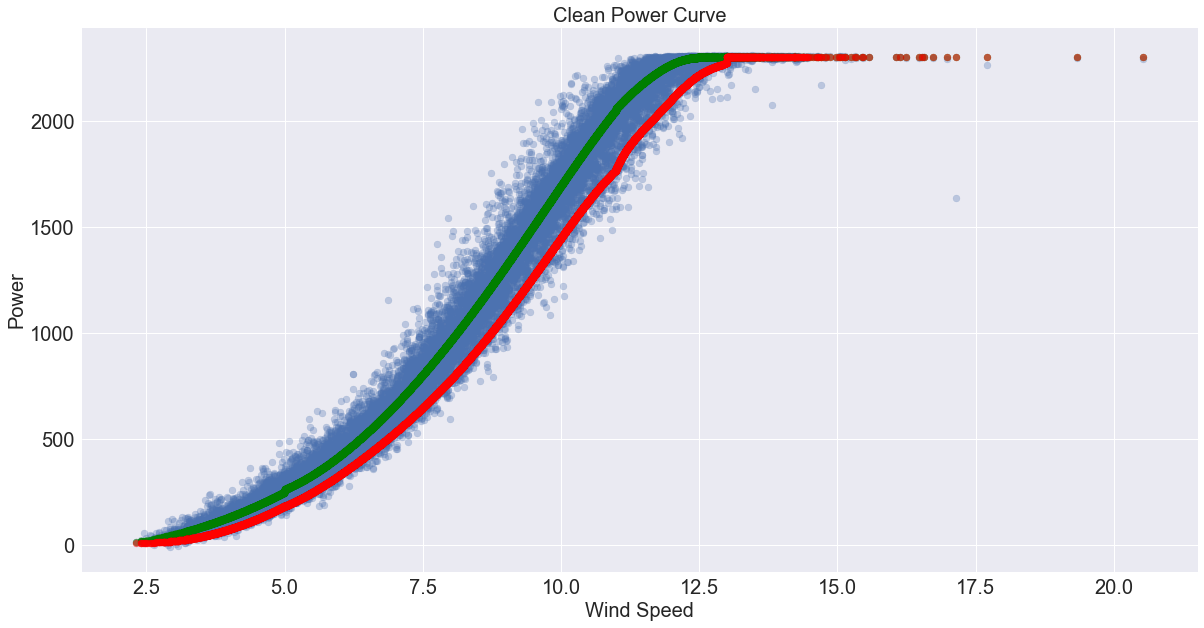

In [21]:
# Plot expected energy on clean data

# x1 = df_clean['wtc_AcWindSp_mean']
# y1 = df_clean['ExpectedEnergy_median'] 

x2 = df_clean['wtc_AcWindSp_mean']
y2 = df_clean['wtc_ActPower_mean'] 

x3 = df_clean['wtc_AcWindSp_mean']
y3 = df_clean['ExpectedEnergy_5th'] 

plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

plt.scatter(x2, y2,alpha=0.3)#, c=c)
# plt.scatter(x1,y1,alpha = 0.5, c='g')
plt.scatter(x3,y3,alpha = 0.5, c='r')

plt.title("Clean Power Curve")
plt.xlabel('Wind Speed')
plt.ylabel('Power')
# plt.legend()
plt.show()

### Turbine Performance Classification
The goal of our classificaiton reports was to determine if a wind turbine was underperforming. In order to do this, we calculated the historical fifth percentile of energy output (low end of energy production). If a turbine was less than or equal to this value then it is deemed to be under performing. 

In [17]:
# Make labels
# insipred by: https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns

def make_class(row):
    if row["wtc_ActPower_mean"] <= row["ExpectedEnergy_5th"]:
        return "1"
    else:
        return "0"

df["Underperformance"] = df.apply(lambda x: make_class(x), axis=1)
df['Underperformance'] = df['Underperformance'].astype(int)

percent = (df['Underperformance'].sum() / len(df))*100
print('Percent of Under Performance Data:',percent,"%")

Percent of Under Performance Data: 26.82522440112058 %


## Classification: Preprocessing of Data

According to several references, many classificaiton models benefit from data scaling. Specifically, it can speed up the training process significantly for certain models (such as support vector machines), and it can prevent certain features from becoming more important than others do the differnce in the scale of their values.

SciKitLearn has some built in functions to expedite this processs. First, however, before this process can begin, the variables must be encoded from the string class variable into a numeric variable that can be interpreted by SciKitLearn.

In [18]:
#Encode the labels (examples found on SKLearn website... need to find address)
le = preprocessing.LabelEncoder()
le.fit(list(df["Underperformance"].unique()))
df["target"] = le.transform(df["Underperformance"])
df = df.replace([np.inf, -np.inf], np.nan).dropna()



#Now the other variables used to train the model need to scaled. First, however, un-need variables need to be dropped.
y = df["target"]

keepcols = ['BoostedRef', 'WindSheer1',
            'wtc_AcWindSp_mean','wtc_NacelPos_mean','wtc_ScInOper_timeon', 
            'WS_Thies_80m_Avg', 'WS_Thies_60m_Avg', 'WS_ICEFREE_Avg',
           'BP_mbar_76m_Avg', 'AirTC_3m_Avg','Icing','Air_density']

data = df[keepcols]


X = preprocessing.scale(data) 

data.columns

Index(['BoostedRef', 'WindSheer1', 'wtc_AcWindSp_mean', 'wtc_NacelPos_mean',
       'wtc_ScInOper_timeon', 'WS_Thies_80m_Avg', 'WS_Thies_60m_Avg',
       'WS_ICEFREE_Avg', 'BP_mbar_76m_Avg', 'AirTC_3m_Avg', 'Icing',
       'Air_density'],
      dtype='object')

# [Modeling and Evaluation (1 of 2 sections) - 70 points]
# Classification Task: Predicting Underperformance

The goal of our classificaiton models was to predict if a wind turbine was under performing based on its operating conditions. This is binary response, either a wind turbine is underperforming or it is not. For Pattern Energy it is important that accuracy of the model be as high as possible. They want to identify any turbine that could be under performing and then do a more indepth analysis on the identified turbines before taking corrective acction. Therefore, we will be evaluating each model using the accuracy metric. While there are some disadvantages to using accuracy (most notabley, it ignores the cost associated with misclassificaiton). However, since each under performing wind turbine will be further examined this is of minimal concern to Pattern. It is more important to them that any turbine that could be under performing be identified for futher investigation.

For our classificaiton models the data was split into traing and test data. A simple 80/20 split was used. This means that 80 percent of the data set was used to train the classification models, and 20 percent was used for testing purposes. This simple approach was used to increase training times.


## KNN Approach

The goal of this classification model was to predict turbine under performance using a KNN approach. This information would be helpful to identify if a turbine is under performing using historical data. 

Two different approaches were used here. First, we ran a simple KNN using different K values. The goal was to see how the defaults for the KNN classifer performed on our data while only chaning the K value. This revealed that adding an increasing number of neighbors did not increase the accuracy of the classifer. We used this information to limit the number of neighbors in the grid search to decrease training time.

Then we did a intensive grid search to see the maximum performance that could be gained from this classifier. The intensive grid search did not have much of an impact on accuracy even though 30 different KNN classiferes were trained and tested.

The best model had the following hyper-paremters:
* **Metric** - Manhattan. This indicates that Manhattan distance was used to calculate distance.
* **K** - 5. This indicates that the optimal number of neights to use 
* **Weights** - Distance. this indicates that optimal performance was acheived when closer neighbors had more influce on the model (rather than all neighbors having the same influce).

### Results of KNN Classifier
The best model has an accuarcy of 92.8 percent.

### Feature Importance
Feature importance was determined in the mini-project. We opted to keep all the same variables that we deemed most important from the mini-project. However, we could attempt to determine which variables are the most important for KNN classificaiton. Looking at the literature, it does not appear that variable importance is a tool used with KNN (https://www.r-bloggers.com/simulated-annealing-feature-selection/)

It could be possible to do a leave one out type analysis with KNN. In this instance you would run a KNN analysis with all but one feature, and then calculate the accuracy. Do this for all feautres in the dataset. The model that has the worst accuracy could mean that the most important feature was dropped from the model. 

I will attempt to do try this method using the model that was selected via the grid search. The top three most important features (according to this method) are show below with the accuracy of the KNN classifier without their inclusion. Remember that the base accuracy was 92.8 percent.

1. 	**wtc_ScInOper_timeon** 	0.907939
2. 	**wtc_AcWindSp_mean** 	0.910321
3. 	**BoostedRef** 	0.910798


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [44]:
for x in range(1,11):
    K=x
    clf = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')
    clf.fit(X_train,y_train)
    p = clf.predict(X_test)
    a = accuracy_score(p,y_test)
    print('Accuracy of classifier with %d neighbors is: %.2f'%(K,a))
# I was getting 92% accuracy just through some basic KNN... I don't think we will get much better.

Accuracy of classifier with 1 neighbors is: 0.91
Accuracy of classifier with 2 neighbors is: 0.92
Accuracy of classifier with 3 neighbors is: 0.92
Accuracy of classifier with 4 neighbors is: 0.92
Accuracy of classifier with 5 neighbors is: 0.92
Accuracy of classifier with 6 neighbors is: 0.92
Accuracy of classifier with 7 neighbors is: 0.92
Accuracy of classifier with 8 neighbors is: 0.92
Accuracy of classifier with 9 neighbors is: 0.92
Accuracy of classifier with 10 neighbors is: 0.92


In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

k = list(range(1,6)) # search up to 5 neighbors
w = ['uniform', 'distance']
m = ['euclidean', 'minkowski', 'manhattan']
parameter_grid = {'n_neighbors': k, 'weights' : w, 'metric': m}

knn = KNeighborsClassifier()

g_seach = GridSearchCV(knn, param_grid=parameter_grid, scoring='accuracy')
g_seach.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
print(g_seach.best_params_)
print()

print("Detailed classification report:")
print()

y_true, y_pred = y_test, g_seach.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print(classification_report(y_true, y_pred))
print()
print("Accuracy:", acc)



Best parameters set found on development set:

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

Grid scores on development set:

Detailed classification report:

             precision    recall  f1-score   support

          0       0.93      0.97      0.95      7698
          1       0.91      0.81      0.86      2795

avg / total       0.93      0.93      0.93     10493


Accuracy: 0.9279519679786524


### KNN Feature Importance

In [22]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan')
model.fit(X_train,y_train)
p = model.predict(X_test)
a = accuracy_score(p,y_test)

In [41]:
# Feature importance was calculated after reviewing this Stack Overflow question:
# https://stackoverflow.com/questions/42088336/how-to-get-the-most-contributing-feature-in-knn-classifier-sklearn
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

keepcols = ['BoostedRef', 'WindSheer1',
            'wtc_AcWindSp_mean','wtc_NacelPos_mean','wtc_ScInOper_timeon', 
            'WS_Thies_80m_Avg', 'WS_Thies_60m_Avg', 'WS_ICEFREE_Avg',
           'BP_mbar_76m_Avg', 'AirTC_3m_Avg','Icing','Air_density']

important_features = pd.DataFrame(columns=["Variable_Dropped", "Accuracy"])

for x in keepcols:
    #set up the variables
    y = df["target"]
    cycle_data = df[keepcols]
    cycle_data = cycle_data.drop(x, axis=1)
    X = preprocessing.scale(cycle_data)
    
    #make sure to keep the sample splitting so that value can be compared
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
    
    #create the model
    model = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan')
    model.fit(X_train,y_train)
    p = model.predict(X_test)
    a = accuracy_score(p,y_test)
    
    #print the results
    print("Accuracy for model with variable: ", x, "dropped is: ", a)
    
    #append to output dataset for later manipulation
    important_features = important_features.append({"Variable_Dropped": x, "Accuracy": a}, ignore_index=True)


Accuracy for model with variable:  BoostedRef dropped is:  0.9107976746402363
Accuracy for model with variable:  WindSheer1 dropped is:  0.928237872867626
Accuracy for model with variable:  wtc_AcWindSp_mean dropped is:  0.910321166491947
Accuracy for model with variable:  wtc_NacelPos_mean dropped is:  0.9249976174592586
Accuracy for model with variable:  wtc_ScInOper_timeon dropped is:  0.9079386257505003
Accuracy for model with variable:  WS_Thies_80m_Avg dropped is:  0.9326217478318879
Accuracy for model with variable:  WS_Thies_60m_Avg dropped is:  0.9322405413132565
Accuracy for model with variable:  WS_ICEFREE_Avg dropped is:  0.9314781282759935
Accuracy for model with variable:  BP_mbar_76m_Avg dropped is:  0.9260459353854951
Accuracy for model with variable:  AirTC_3m_Avg dropped is:  0.9315734299056514
Accuracy for model with variable:  Icing dropped is:  0.9286190793862575
Accuracy for model with variable:  Air_density dropped is:  0.9310016201277042


In [44]:
print("The most important features are:")
print()
important_features.sort_values(by=["Accuracy"])

The most important features are:



,Variable_Dropped,Accuracy
4,wtc_ScInOper_timeon,0.907939
2,wtc_AcWindSp_mean,0.910321
0,BoostedRef,0.910798
3,wtc_NacelPos_mean,0.924998
8,BP_mbar_76m_Avg,0.926046
1,WindSheer1,0.928238
10,Icing,0.928619
11,Air_density,0.931002
7,WS_ICEFREE_Avg,0.931478
9,AirTC_3m_Avg,0.931573


## SVM Approach
This model was repurposed from the Classification mini-project. However, the data set is now larger (an entire year's worth of data). The goal is the same, to predict poor performing turbines. 

### Model Creation and Parameter Optimization With Grid Search

Running the SVC classifier within SciKit Learn proved to be to costly computationally. As a result, we proceeded with a differnt SVM Classifier. Specifically, we use the SGDClassifier which utilized stochastic gradient descent and greatly increased training rates.

Since there are many possible parameters that can be put into the classifer, we ran through various alphas (or a penalty term), learning rates, and learning rate schedules to find the strongest possible model based on the input parameters. This was done using a grid search.

http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
The best SGDClassifer had the following attributes: 

* **Alpha** - 1e-05
* **Eta0**  - 0.5
* **Learning rate** - 'invscaling'

## Results of SVM Classifier
The resulting model had a 89.12 percent. This is very similar accuarcy to our previous model (a sligh decrease which can easily be explained by different in training data). However, the hyper parameters change significantly between this model and the model from the mini-project.

In [13]:
# Thanks to sklearn for a great example: 
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
from sklearn import linear_model

# Set the parameters by cross-validation
clist = [0.1, 1, 10, 100]
tuned_parameters = [#{'kernel': ['rbf'], 'C': clist},
                    {'kernel': ['linear'], 'C': clist}
#                     {'kernel': ['poly'], 'C': clist},
#                     {'kernel': ['sigmoid'], 'C': clist}
                   ]

alphas = 10.0**-np.arange(1,7)
tp = [{'alpha':alphas, 'learning_rate':['constant', 'optimal', 'invscaling'], 'eta0': [0.01, 0.1, 0.5, 1.0]}]

clf = GridSearchCV(linear_model.SGDClassifier(), tp)
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
# print("The model is trained on the full development set.")
# print("The scores are computed on the full evaluation set.")
# print()
y_true, y_pred = y_test, clf.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print(classification_report(y_true, y_pred))
print()
print("Accuracy:", acc)

Best parameters set found on development set:

{'alpha': 1e-05, 'eta0': 0.5, 'learning_rate': 'invscaling'}

Grid scores on development set:

0.845 (+/-0.003) for {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'constant'}
0.844 (+/-0.004) for {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'optimal'}
0.844 (+/-0.004) for {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'invscaling'}
0.827 (+/-0.043) for {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant'}
0.844 (+/-0.004) for {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'optimal'}
0.845 (+/-0.004) for {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'invscaling'}
0.756 (+/-0.131) for {'alpha': 0.1, 'eta0': 0.5, 'learning_rate': 'constant'}
0.844 (+/-0.004) for {'alpha': 0.1, 'eta0': 0.5, 'learning_rate': 'optimal'}
0.845 (+/-0.004) for {'alpha': 0.1, 'eta0': 0.5, 'learning_rate': 'invscaling'}
0.691 (+/-0.129) for {'alpha': 0.1, 'eta0': 1.0, 'learning_rate': 'constant'}
0.844 (+/-0.004) for {'alpha': 0.1, 'eta0': 1.0, 'learning_rate': 'optim

### SVM Feature Importance and Coefficent Interpretation
Since we used a linear SVM we can use the coefficents of the classfier to determine feature importance as it is part of the interpretation of the coefficients.

The coefficent of each support vector tells us its impact on the predicted class. Taking a dot product of a point with the coefficents will tell us the classificaiton of the point. Thus positive values tend to push a point toward the positive class, and negative coefficeints push to the negative classificaiton. Thus large values, either positive or negative, have more influce on the model. A plot of this information is shown below. Blue values indicate that the coefficient if positive, red indicate that it is negative.

The top three most influential vectors are:

1. wtc_ScInOper_timeon
2. wtc_AcWindSp_mean
3. BoostedRef


In [77]:
from sklearn.linear_model import SGDClassifier
svm_model = SGDClassifier(alpha=1e-05, eta0=0.5, learning_rate='invscaling')
svm_model.fit(X_train, y_train)

test = svm_model.coef_
my_zip = list(zip(keepcols, test.tolist()[0]))
svm_features = pd.DataFrame.from_records(my_zip)

Text(0,0.5,'SVM Coefficients')

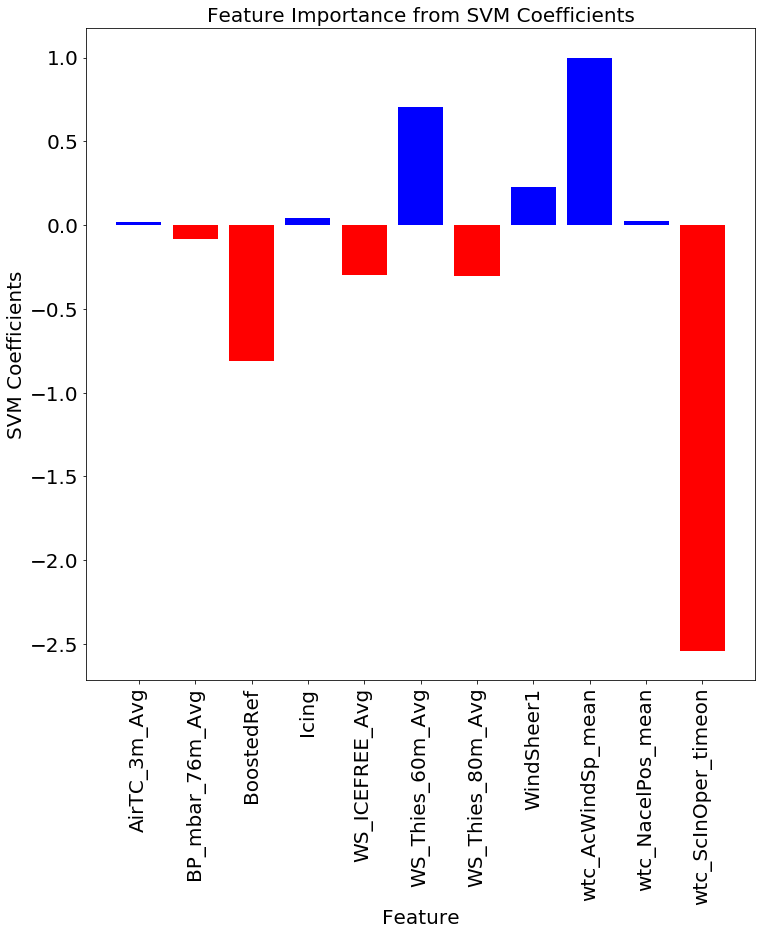

In [98]:
plt.figure(figsize=(12,12))
colors = ['red' if c < 0 else 'blue' for c in svm_features[1]]
plt.bar(svm_features[0], svm_features[1], color=colors)
plt.xticks(rotation='vertical')
plt.title("Feature Importance from SVM Coefficients", fontsize=20)
plt.xlabel("Feature")
plt.ylabel("SVM Coefficients")

In [110]:
svm_features[1].apply(lambda x: abs(x)).sort_values()

9     0.018883
3     0.023848
10    0.043363
8     0.084013
1     0.225038
7     0.297244
5     0.304193
6     0.707417
0     0.809709
2     1.000857
4     2.539049
Name: 1, dtype: float64

In [113]:
svm_features[0][[4,2,0]]

4    wtc_ScInOper_timeon
2      wtc_AcWindSp_mean
0             BoostedRef
Name: 0, dtype: object

## Random Forest Classifier

The final model technique that we chose to utilise for classification of under performance was the random forest classifier. A random forest classifier was chosen as they are known for their excellent predictability and accuracy. Another strength of the random forest classifier is that they can score new data quickly once the classifier has been trained. 


### Classification Setup
The classification is based on our definition of underperformance. Using the 26.8% of the data that shows underperformance, we have a boolean classification system. Then we setup the variables necessary to classify our data.

The resulting model had an accuracy of 91.93 percent. 

In [65]:
#Encode the labels (examples found on SKLearn website... need to find address)
le = preprocessing.LabelEncoder()
le.fit(list(df["Underperformance"].unique()))

df["target"] = le.transform(df["Underperformance"])
df = df.replace([np.inf, -np.inf], np.nan).dropna()



#Now the other variables used to train the model need to scaled. 
#First, however, un-need variables need to be dropped.
#classifier target is based on our determination of when the turbine is underperforming
cl_target = df['target']


classcols = ['BoostedRef', 'WindSheer1',
            'wtc_AcWindSp_mean','wtc_NacelPos_mean','wtc_ScInOper_timeon', 
            'WS_Thies_80m_Avg', 'WS_Thies_60m_Avg', 'WS_ICEFREE_Avg',
           'BP_mbar_76m_Avg', 'AirTC_3m_Avg','Icing','Air_density','target']

cl_data = df[classcols]

#regression target is based on the actual power output from the turbine
y = df["wtc_ActPower_mean"]

keepcols = ['BoostedRef', 'WindSheer1',
            'wtc_AcWindSp_mean','wtc_NacelPos_mean','wtc_ScInOper_timeon', 
            'WS_Thies_80m_Avg', 'WS_Thies_60m_Avg', 'WS_ICEFREE_Avg',
           'BP_mbar_76m_Avg', 'AirTC_3m_Avg','Icing','Air_density']

data = df[keepcols]


X = preprocessing.scale(data) 

data.columns

Index(['BoostedRef', 'WindSheer1', 'wtc_AcWindSp_mean', 'wtc_NacelPos_mean',
       'wtc_ScInOper_timeon', 'WS_Thies_80m_Avg', 'WS_Thies_60m_Avg',
       'WS_ICEFREE_Avg', 'BP_mbar_76m_Avg', 'AirTC_3m_Avg', 'Icing',
       'Air_density'],
      dtype='object')

In [66]:
#Code from https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
# Our data set is divided into a test and training set, randomly
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# Create two new dataframes, one with the training rows, one with the test rows
train, test = df[df['is_train']==True], df[df['is_train']==False]

# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 39398
Number of observations in the test data: 13066


In [67]:
# Create a list of the feature column's names
feat = df[keepcols]

features = feat.columns
# View features
features

#create target
target = train['target']

In [68]:
#code from https://chrisalbon.com/machine_learning/trees_and_forests/random_forest_classifier_example/
#load random forest classifier
from sklearn.ensemble import RandomForestClassifier

#set random seed
np.random.seed(0)

### Classification parameter change 1

In [69]:
#train the random forest classifier
#Try different parameters and compare

#Parameter try 1
clf = RandomForestClassifier(n_jobs=2, random_state=0, max_depth=10)

clf.fit(train[features], target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [70]:
#Apply the classifier to the test data set
y_pred = clf.predict(test[features])

In [71]:
# View the predicted probabilities of the first 10 observations
clf.predict_proba(test[features])[0:10]

array([[0.92896823, 0.07103177],
       [0.96175837, 0.03824163],
       [0.95202996, 0.04797004],
       [0.94846957, 0.05153043],
       [0.95202996, 0.04797004],
       [0.9484496 , 0.0515504 ],
       [0.47488479, 0.52511521],
       [0.68446927, 0.31553073],
       [0.02352941, 0.97647059],
       [0.00821491, 0.99178509]])

In [72]:
preds = clf.predict(test[features])
preds[0:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1], dtype=int64)

In [73]:
# Create confusion matrix
pd.crosstab(test['target'], preds, rownames=['Actual Target'], colnames=['Predicted Target'])

Predicted Target,0,1
Actual Target,,
0,9364,156
1,899,2647


In [74]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(test['target'], y_pred))

Accuracy: 0.9192560844941069


### Results of Parameter Change 1
The above table shows how our power classifications match up with the actual power recorded.

In [75]:
# View a list of the features and their importance scores
list(zip(train[features], clf.feature_importances_))

[('BoostedRef', 0.16444588963252002),
 ('WindSheer1', 0.024392369733933484),
 ('wtc_AcWindSp_mean', 0.2627703278144814),
 ('wtc_NacelPos_mean', 0.018513250037489694),
 ('wtc_ScInOper_timeon', 0.3065831101016764),
 ('WS_Thies_80m_Avg', 0.05228906902318899),
 ('WS_Thies_60m_Avg', 0.0238233034948651),
 ('WS_ICEFREE_Avg', 0.07637059309573623),
 ('BP_mbar_76m_Avg', 0.0320114602041405),
 ('AirTC_3m_Avg', 0.01841538811976129),
 ('Icing', 0.0003607485888840122),
 ('Air_density', 0.02002449015332284)]

### Influential Features for Parameter Change 1
The most influential features that helped predict underperformance were:  wtc_ScInOper_timeon at 31%, wtc_AcWindSp_mean at 26%, BoostedRef at 16%, and WS_ICEFREE_Avg at 8%.

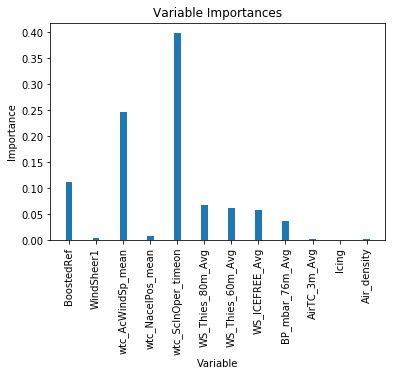

In [147]:
#http://dataaspirant.com/2017/04/21/visualize-decision-tree-python-graphviz/
# reminder
# X = data
# y = df.target

pylab.bar (keepcols, clf.feature_importances_, 1/4)
pylab.xticks(keepcols, rotation='vertical')
pylab.ylabel('Importance'); pylab.xlabel('Variable'); pylab.title('Variable Importances');
pylab.show()

# import altair as alt
# from vega_datasets import data
# alt.renderers.enable('notebook')

# alt.Chart(clf.feature_importances_).mark_bar().encode(
#     y='Percentage Explained',
#     x='train[features]')


### Classification Parameter Change 2

In [91]:
clf = RandomForestClassifier(n_jobs=2, random_state=5, max_depth=10, max_leaf_nodes=5)

clf.fit(train[features], target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=5,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

In [92]:
#Apply the classifier to the test data set
clf.predict(test[features])

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [93]:
# View the predicted probabilities of the first 10 observations
clf.predict_proba(test[features])[0:10]

array([[0.86582343, 0.13417657],
       [0.86571961, 0.13428039],
       [0.86571961, 0.13428039],
       [0.86571961, 0.13428039],
       [0.86571961, 0.13428039],
       [0.86582343, 0.13417657],
       [0.86582343, 0.13417657],
       [0.86582343, 0.13417657],
       [0.12030681, 0.87969319],
       [0.12438387, 0.87561613]])

In [94]:
preds = clf.predict(test[features])
preds[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int64)

In [95]:
# Create confusion matrix
pd.crosstab(test['target'], preds, rownames=['Actual Target'], colnames=['Predicted Target'])

Predicted Target,0,1
Actual Target,,
0,9448,72
1,1766,1780


In [96]:
#Apply the classifier to the test data set
y_pred = clf.predict(test[features])

In [97]:
print("Accuracy:",metrics.accuracy_score(test['target'], y_pred))

Accuracy: 0.8593295576304913


In [98]:
# View a list of the features and their importance scores
list(zip(train[features], clf.feature_importances_))

[('BoostedRef', 0.04986159463817053),
 ('WindSheer1', 0.017747678338269575),
 ('wtc_AcWindSp_mean', 0.2723883088212099),
 ('wtc_NacelPos_mean', 0.004330952384310781),
 ('wtc_ScInOper_timeon', 0.4381380226880758),
 ('WS_Thies_80m_Avg', 0.02403731415710093),
 ('WS_Thies_60m_Avg', 0.07540872386723806),
 ('WS_ICEFREE_Avg', 0.09297746497538266),
 ('BP_mbar_76m_Avg', 0.02510994013024178),
 ('AirTC_3m_Avg', 0.0),
 ('Icing', 0.0),
 ('Air_density', 0.0)]

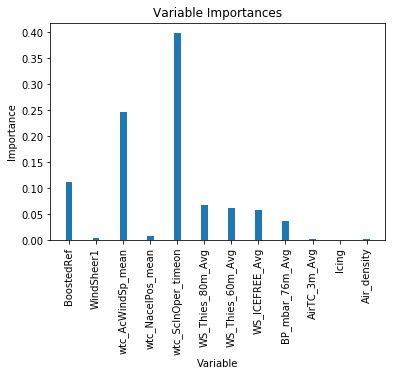

In [145]:
pylab.bar (keepcols, clf.feature_importances_, 1/4)
pylab.xticks(keepcols, rotation='vertical')
pylab.ylabel('Importance'); pylab.xlabel('Variable'); pylab.title('Variable Importances');
pylab.show()

#### The above table shows how our power classifications match up with the actual power recorded. 

#### Influential Features For parameter option #2

The most influential features that helped predict underperformance were:  wtc_ScInOper_timeon at 44%, wtc_AcWindSp_mean at 27%, WS_ICEFREE_Avg at 9%, and WS_Thies_60m_Avg at 7%.

### Parameter Change 3

In [100]:
clf = RandomForestClassifier(n_jobs=2, random_state=10, max_depth=15, max_leaf_nodes=10)

clf.fit(train[features], target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [101]:
#Apply the classifier to the test data set
clf.predict(test[features])

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [102]:
# View the predicted probabilities of the first 10 observations
clf.predict_proba(test[features])[0:10]

array([[0.89028253, 0.10971747],
       [0.87651187, 0.12348813],
       [0.87651187, 0.12348813],
       [0.86429562, 0.13570438],
       [0.87651187, 0.12348813],
       [0.87651187, 0.12348813],
       [0.75193569, 0.24806431],
       [0.84099295, 0.15900705],
       [0.0667918 , 0.9332082 ],
       [0.16398701, 0.83601299]])

In [103]:
preds = clf.predict(test[features])
preds[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int64)

In [104]:
# Create confusion matrix
pd.crosstab(test['target'], preds, rownames=['Actual Target'], colnames=['Predicted Target'])

Predicted Target,0,1
Actual Target,,
0,9417,103
1,1319,2227


In [105]:
#Apply the classifier to the test data set
y_pred = clf.predict(test[features])

print("Accuracy:",metrics.accuracy_score(test['target'], y_pred))

Accuracy: 0.8911679167304455


In [106]:
# View a list of the features and their importance scores
list(zip(train[features], clf.feature_importances_))

[('BoostedRef', 0.11220410021871248),
 ('WindSheer1', 0.004630145597117373),
 ('wtc_AcWindSp_mean', 0.24653823222422497),
 ('wtc_NacelPos_mean', 0.008824448374224785),
 ('wtc_ScInOper_timeon', 0.39852225509995826),
 ('WS_Thies_80m_Avg', 0.06713619623570835),
 ('WS_Thies_60m_Avg', 0.06214813655927528),
 ('WS_ICEFREE_Avg', 0.05743721568482535),
 ('BP_mbar_76m_Avg', 0.037557327048976005),
 ('AirTC_3m_Avg', 0.0020180446879031035),
 ('Icing', 0.0),
 ('Air_density', 0.002983898269074011)]

#### The above table shows how our power classifications match up with the actual power recorded.

#### Import Features for Parameter Option 3
The most influential features that helped predict underperformance were: wtc_ScInOper_timeon at 40%, wtc_AcWindSp_mean at 25%, BoostedRef at 11%, and WS_Thies_80m_Avg at 7%.

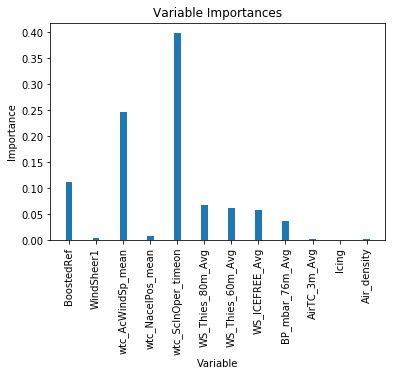

In [146]:
# alt.Chart(clf.feature_importances_).mark_bar().encode(
#     y='Percentage Explained',
#     x='train[features]')
pylab.bar (keepcols, clf.feature_importances_, 1/4)
pylab.xticks(keepcols, rotation='vertical')
pylab.ylabel('Importance'); pylab.xlabel('Variable'); pylab.title('Variable Importances');
pylab.show()

### Random Forest Influential Features: Summary

With each parameter change, the accuracy changed significantly. 

* With Parameter set 1: the random_state is 0 and the max_depth is 10. This produced an accuracy of 92%.

* With Parameter set 2: the random_state is 5, max_depth is 10, and max_nodes is 5. This produced an accuracy of 86%.

* With Parameter set 3: the random_state is 10, max_depth is 15, and max_nodes is 10. This produced an accuracy of 89%.

In addition to accuracy changes, the important features changed and their percentage of influence changed significantly. 


## Classification: Conclusion

We trained and tested three different classifiers to predict if a wind turbine is under-performing or not. These models included K Nearest Neighbors, Support Vector Machine, and a Random Forest. We opted to compare the models based on accuracy. Below is a comparison of the models and the accuracy.

* **SVM** - Accuracy: 89.12 Percent
* **KNN** - Accuracy: 92.8 Percent
* **Random Forest** - Accuracy: 91.93 Percent

The KNN and Random Forest models perfromed very similarly. Strickly speaking, the KNN classifier had the best accuracy and using this metric alone it should be chosen as the best classificaiton model. However, for deployment purposes other metrics should be considered, such as run-time of the chosen model.

**On Feature Importance**

Time and again the most important features to each classification model were:
1. stc_ScInOper_timeon
2. wtc_Act_windSp_mean
3. BootedRef

This makes a great deal of since. The inoperable time has a huge impact on power output, and we based under performance on power output. Similarly, wind speed is the most important factor for power output (assuming that the wind turbine is healthy. And finally, BootedRef is a reference to the actual power output with some padding. Thus it makes sense that it would be incredibly important feature for the classificaiton models.

### Are there statistical differences between the models? 
I wanted to look see if there was a difference between the worst performing classificaiton model (the SVM) and the best performing model (KNN). I figure that there would probably not be a differnce between the two close models, but I suspected that there was a statistical differnce between the two worst models. In order to compare them I compared the cross validation score (10 fold), and determined if there was a statistical difference between the two models at 95 percent confidence using a paired t-test.

According to the code below there is not a statitical difference between the SVM and KNN models at 95 percent confidence.

In [119]:
#code borrowed from Class Unit 7 notebook
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

cv=StratifiedKFold(n_splits=10)
acc1 = cross_val_score(model, X, y=y, cv=cv)
acc2 = cross_val_score(svm_model, X, y=y, cv=cv)

t = 2.26 / np.sqrt(10)

e = (1-acc1)-(1-acc2)
# std1 = np.std(acc1)
# std2 = np.std(acc2)
stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot )
print (np.mean(acc1), np.mean(acc2))

Range of: -0.021088940486474167 0.0063791721554672665
0.8897522157561368 0.8823973315906335


# Regression Task - Prediciton of Power Output

Energy output is of critical importance to a wind farm. Our group wanted to determine if we could predict power output using KNN regression, Random Forests, and a traiditonal regression apprach. 


## KNN Regression Approach
Two different KNN Regressors were built. One using non-transformed data (that is using only the scaled data). Another model was built using the results of a Principal Component Analysis (PCA).


## Attempt 1: KNN Regression using non transformed data
KNN can also be used for prediciton continuous output by regressing on the nearest neighbors. We used the best classifier from the grid search to generate the hyper-parameters used by the regressor. The intial results were excellent. We acheived an R2 of 0.9274 indicating that the model could explain nearly 93 percent of the variation found in the data.

In [14]:
y2 = df["wtc_ActPower_mean"]

keepcols = ['WindSheer1',
            'wtc_AcWindSp_mean','wtc_NacelPos_mean','wtc_ScInOper_timeon', 
            'WS_Thies_80m_Avg', 'WS_Thies_60m_Avg', 'WS_ICEFREE_Avg',
           'BP_mbar_76m_Avg', 'AirTC_3m_Avg','Icing','Air_density']

data2 = df[keepcols]

X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, y2, test_size=0.2)

In [15]:
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

reg = KNeighborsRegressor(n_neighbors=5, metric='manhattan', weights='distance')

reg.fit(X_train2, y_train2)
pred2 = reg.predict(X_test2)

reg.score(X_test2, y_test2)

0.9273608641802736

## Plotting Regression Results
Two plots are shown below. The first is a scatter plot that shows test data plotted against wind speed. The second show the same scatter plot but with the predicted values plotted on top of the actual data. We can see that the KNN regressor does a good job maintaining the overall shape of the data. The regressor also does a good job predicting variables that do not follow the overall shape of power curve. 

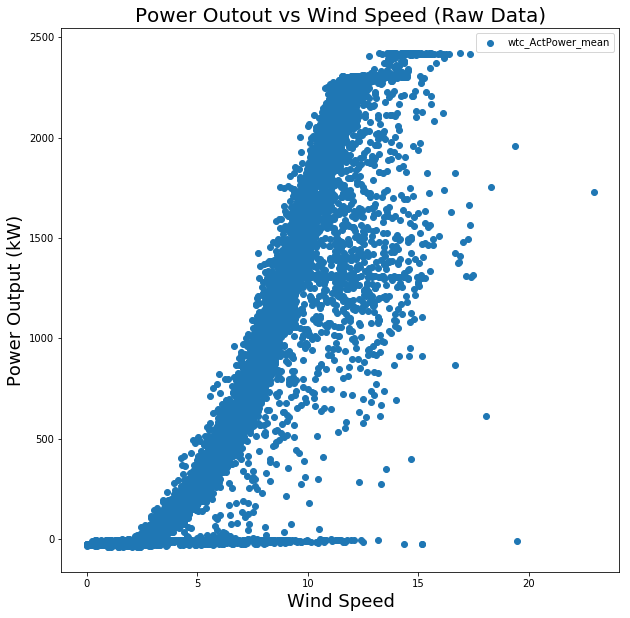

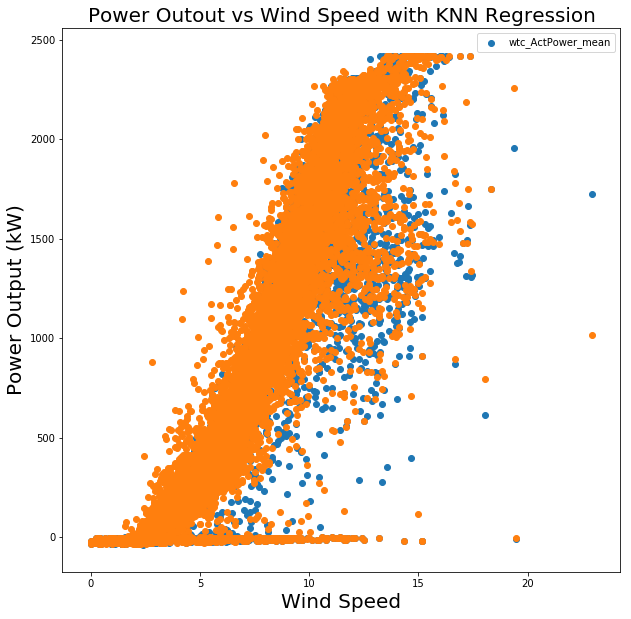

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(x=X_test2["wtc_AcWindSp_mean"], y=y_test2)
plt.axis('tight')
plt.ylabel("Power Output (kW)", fontsize=18)
plt.xlabel("Wind Speed", fontsize=18)
plt.legend()
plt.title("Power Outout vs Wind Speed (Raw Data)", fontsize=20)
plt.show()

print()

plt.figure(figsize=(10,10))
plt.scatter(x=X_test2["wtc_AcWindSp_mean"], y=y_test2)
plt.scatter(X_test2["wtc_AcWindSp_mean"], pred2)
plt.ylabel("Power Output (kW)", fontsize=20)
plt.xlabel("Wind Speed", fontsize=20)
plt.axis('tight')
plt.legend()
plt.title("Power Outout vs Wind Speed with KNN Regression", fontsize=20)
plt.show()

## KNN Regression Attempt 2 - Implementation of PCA
PCA allowed us to reduce the features used in the KNN regression while maintaining a high R2 value. We did experience some interesting results. 

The first five principal components explaint over 99% of the variance in the data. However, the resulting KNN regression had an R2 of 0.8404. 

Using the first 6 principle components did not explain much more variance in the data, however, there was a large increase in model fit. The R2 increased to 0.9356 or a gain of 0.0952.

This means that PCA KNN Regression yielded slightly better results with roughly half of the number of featuers using the same hyper parameters. However, this additional increase in model performance is not worth the decrease in interpretability from the regular model.

In [85]:
# Using 5 Principal components
from sklearn.decomposition import PCA

pca2 = PCA(n_components=5) # there are 11 features
pca2.fit(data2)

pca_X_train2 = pca2.transform(X_train2)
pca_X_test2 = pca2.transform(X_test2)


print(pca2.explained_variance_ratio_)
print(sum(pca2.explained_variance_ratio_))

reg_pca = KNeighborsRegressor(n_neighbors=5, metric='manhattan', weights='distance')
reg_pca.fit(pca_X_train2, y_train2)
pred_pca = reg_pca.predict(pca_X_test2)

reg_pca.score(pca_X_test2, y_test2)

[7.98850329e-01 1.94554726e-01 4.18285824e-03 1.87375758e-03
 4.60097880e-04]
0.9999217682499959


0.8404323116710646

In [86]:
#Using 6 principal components
from sklearn.decomposition import PCA

pca2 = PCA(n_components=6) # there are  11 features
pca2.fit(data2)

pca_X_train2 = pca2.transform(X_train2)
pca_X_test2 = pca2.transform(X_test2)


print(pca2.explained_variance_ratio_)
print(sum(pca2.explained_variance_ratio_))

reg_pca = KNeighborsRegressor(n_neighbors=5, metric='manhattan', weights='distance')
reg_pca.fit(pca_X_train2, y_train2)
pred_pca = reg_pca.predict(pca_X_test2)

reg_pca.score(pca_X_test2, y_test2)

[7.98850329e-01 1.94554726e-01 4.18285824e-03 1.87375758e-03
 4.60097880e-04 7.32440830e-05]
0.9999950123330369


0.9355962752996375

## Polynomial Regression

During the mini-project we noticed that the fit of our data did not follow the overall shape of the training data as well as we would like. After talking to some subject matter experts at Pattern Energy it was determined that we should try to model the data using a polynomial relationship. 

This was done using some of the code from the 'EducationDataNC' notebooks where the CappedLinearRegression was used to limit predictions. 

In [23]:
y = df_clean["wtc_ActPower_mean"]

dropcols = ['wtc_ActPower_mean','Description', 'Name','WindSheer1','PowerDelta','wtc_ActPower_stddev']

X = df_clean.drop(dropcols, axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

class CappedLinearRegression(LinearRegression):
    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), y.min(), y.max()) 

### Grid Search
We opted to use a grid search to find the best hyper-paremeters for this model. The parameters adjusted were the degree polynomial for the transformation, if the model is to be normalized, and if the intercept is to be fit. This was done using a ten fold cross-validation with a 20/80 split for training and testing. The scoring parameter used is the R-squared.

### Polynomrial Regression Results

The grid search determined that a two degree polynomial resutled in the best fit. The resulting model perfromed execeptionally well with an R2 of 0.99 indicating that nearly all of the variation in the data can be explained by the model.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Possible Parameters:
    # 'memory',
    #  'steps',
    #  'poly',
    #  'linear',
    #  'poly__degree',
    #  'poly__include_bias',
    #  'poly__interaction_only',
    #  'linear__copy_X',
    #  'linear__fit_intercept',
    #  'linear__n_jobs',
    #  'linear__normalize'

parameters = {'poly__degree':[2,3],
              'linear__normalize':(True,False), 
              'linear__fit_intercept':(True,False)}

model = Pipeline([('poly', PolynomialFeatures()),
                      ('linear', CappedLinearRegression())])

regGridSearch = GridSearchCV(estimator=model
                   , verbose=3 #high number gives more description
                   , param_grid=parameters
                   , cv=cv
                   , n_jobs=-1 # all CPUs
                   , scoring='r2')

#Perform hyperparameter search to find the best combination of parameters for our data
# regGridSearch.fit(X, y) #UNCOMMENT TO RUN 

In [29]:
# Execute model with best parameters from Grid Search

from sklearn.model_selection import cross_val_score

model = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)),
                  ('linear', CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False))])
model.fit(X, y)
y_hat = model.predict(X)

acc = cross_val_score(model, X, y, cv=cv,scoring='r2')
print('Max R-squared: ',acc.max())

Max R-squared:  0.990064169428


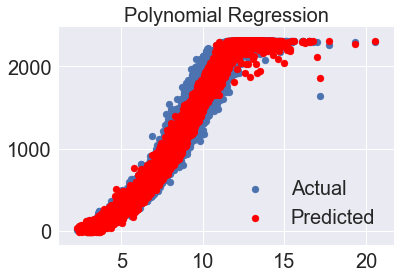

In [30]:
plt.scatter(x=X["wtc_AcWindSp_mean"], y=y, label='Actual')
plt.scatter(x=X["wtc_AcWindSp_mean"], y=y_hat, c='r', label='Predicted')
plt.axis('tight')
plt.legend()
plt.title("Polynomial Regression")
plt.show()

## Lasso Regression

In [27]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

model = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

regGridSearch = GridSearchCV(estimator=model
                   , verbose=3
                   , param_grid=parameters
                   , cv=cv
                   , n_jobs=-1
                   , scoring='r2')

regGridSearch.fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   16.0s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.001, 0.1, 1, 10, 20], 'selection': ['cyclic', 'random'], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=3)

In [35]:
# Execute model with best parameters from Grid Search
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

model = Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False)

model.fit(X, y)
y_hat = model.predict(X)

acc = cross_val_score(model, X, y, cv=3,scoring='r2')
print('Max R-squared: ',acc.max())

Max R-squared:  0.963065209304


## Ridge Regression

In [29]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

model = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=1000, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parameters = {'alpha': alpha, 'solver': solver}

regGridSearch = GridSearchCV(estimator=model
                   , verbose=3
                   , param_grid=parameters
                   , cv=cv
                   , n_jobs=-1
                   , scoring='r2')

regGridSearch.fit(X, y)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   47.1s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='auto', tol=0.0001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20], 'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=3)

In [36]:
# Execute model with best parameters from Grid Search
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

model = Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='auto', tol=0.0001)

model.fit(X, y)
y_hat = model.predict(X)

acc = cross_val_score(model, X, y, cv=3,scoring='r2')
print('Max R-squared: ',acc.max())

Max R-squared:  0.952737869926


## ElasticNet Regression

We are not sure why the ElasticNet version of linear regression gave negative R-square. 

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

model = ElasticNet(fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)
 
#Test parameters
l1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
alpha = [0.001, 0.1, 1, 10]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'l1_ratio': l1_ratio, 'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

regGridSearch = GridSearchCV(estimator=model
                   , verbose=3
                   , param_grid=parameters
                   , cv=cv
                   , n_jobs=-1
                   , scoring='r2')

regGridSearch.fit(X, y)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   36.9s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.75, 1], 'alpha': [0.001, 0.1, 1, 10], 'selection': ['cyclic', 'random'], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=3)

In [37]:
# Executefrom sklearn.linear_model 
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score

model = ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

model.fit(X, y)
y_hat = model.predict(X)

acc = cross_val_score(model, X, y, cv=3,scoring='r2')
print('Max R-squared: ',acc.max())

Max R-squared:  -0.0170456144688


## Random Forest Regression

The regression target is based on the actual power output of the turbine, "wtc_ActPower_mean". We define a separate set of variables we wish to use to predict the power output.

In [108]:
#Code from https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
y_a = np.array(y, dtype=pd.Series)
print(y_a)

train_y_a, test_y_a, train_data, test_data = train_test_split(y_a, data, test_size = 0.25, random_state = 42)
train_y_r = np.atleast_2d(train_y_a)
test_y_r = np.atleast_2d(test_y_a)
print(train_y_r)
print(test_y_r)
train_y_s = train_y_r.reshape(-1,1)
print(train_y_s)
test_y_s = test_y_r.reshape(-1,1)
print(test_y_s)

[1554.1629999999998 1027.646 689.9637 ... -27.846870000000003 -27.76335
 -27.61562]
[[1586.6570000000002 236.7694 1769.4520000000002 ... 1097.237 551.3526
  932.595]]
[[2138.28 309.7698 2302.3179999999998 ... 433.6547 1971.317 319.1144]]
[[1586.6570000000002]
 [236.7694]
 [1769.4520000000002]
 ...
 [1097.237]
 [551.3526]
 [932.595]]
[[2138.28]
 [309.7698]
 [2302.3179999999998]
 ...
 [433.6547]
 [1971.317]
 [319.1144]]


In [109]:
print('Training Features Shape:', train_y_s.shape)
print('Training Labels Shape:', train_data.shape)
print('Testing Features Shape:', test_y_s.shape)
print('Testing Labels Shape:', test_data.shape)

Training Features Shape: (39348, 1)
Training Labels Shape: (39348, 12)
Testing Features Shape: (13116, 1)
Testing Labels Shape: (13116, 12)


### Regression parameters setting 1

In [117]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 10 decision trees
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)


In [118]:
# Train the model on training data
# rf.fit(train_y_s, train_data);
rf.fit(train_data, train_y_a);

In [111]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_data)

# Calculate the absolute errors
errors = abs(predictions - test_y_a)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'kWh.')

Mean Absolute Error: 58.4 kWh.


In [112]:
score = rf.score(test_data, test_y_a)
print(score)

# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

0.9833139688814232


#### Results of Parameter Setting 1
The results from the first choice in parameters (n_estimators=10 and the rest default) had a very high accuracy of 98.3%. With n_estimators set at 10 the regression will use a max of 10 trees. More trees increases accuracy but slows the code down.

### Regression parameters setting 2

In [119]:
# Instantiate model with 50 decision trees
rf = RandomForestRegressor(n_estimators = 50, random_state = 42)

In [120]:
# Train the model on training data
# rf.fit(train_y_s, train_data);
rf.fit(train_data, train_y_a);

In [121]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_data)

# Calculate the absolute errors
errors = abs(predictions - test_y_a)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'kWh.')

Mean Absolute Error: 55.68 kWh.


In [122]:
score = rf.score(test_data, test_y_a)
print(score)

0.9846850572618667


#### Results of Parameter Setting 2
The results from the second choice in parameters (n_estimators=50 and the rest default) had a slightly higher accuracy of 98.4%. With n_estimators set at 50 the regression will use 50 trees. More trees increases accuracy but slows the code down.

### Regression parameters setting 3

In [128]:
# Instantiate model with 50 decision trees and with oob_score set to True
rf = RandomForestRegressor(n_estimators = 50, max_features = .2, oob_score=True, random_state = 42)

In [129]:
# Train the model on training data
# rf.fit(train_y_s, train_data);
rf.fit(train_data, train_y_a);

In [130]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_data)

# Calculate the absolute errors
errors = abs(predictions - test_y_a)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'kWh.')

Mean Absolute Error: 70.15 kWh.


In [131]:
score = rf.score(test_data, test_y_a)
print(score)

0.9802697337763238


#### Results of Parameter Setting 3
The results from the third choice in parameters (n_estimators=50, max_features=20%, and oob_score set to true) had a slightly lower accuracy of 98.0%. With n_estimators set at 50 the regression will use 50 trees. More trees increases accuracy but slows the code down. Max_features limits the number of feartures that are allowed to try in each tree. Setting the oob_score at true tags each observation that is in different trees. Then for every tree that doesn't use a particular observation, it finds the maximum score.

In [134]:
# Rerunning the second parameters for all future efforts

# Instantiate model with 50 decision trees
rf = RandomForestRegressor(n_estimators = 50, random_state = 42)

# Train the model on training data
rf.fit(train_data, train_y_a);

# Use the forest's predict method on the test data
predictions = rf.predict(test_data)

# Calculate the absolute errors
errors = abs(predictions - test_y_a)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'kWh.')

Mean Absolute Error: 55.68 kWh.


In [135]:
score = rf.score(test_data, test_y_a)
print(score)

0.9846850572618667


In [136]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(keepcols, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)


# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: wtc_AcWindSp_mean    Importance: 0.87
Variable: BoostedRef           Importance: 0.07
Variable: wtc_ScInOper_timeon  Importance: 0.05
Variable: WindSheer1           Importance: 0.0
Variable: wtc_NacelPos_mean    Importance: 0.0
Variable: WS_Thies_80m_Avg     Importance: 0.0
Variable: WS_Thies_60m_Avg     Importance: 0.0
Variable: WS_ICEFREE_Avg       Importance: 0.0
Variable: BP_mbar_76m_Avg      Importance: 0.0
Variable: AirTC_3m_Avg         Importance: 0.0
Variable: Icing                Importance: 0.0
Variable: Air_density          Importance: 0.0


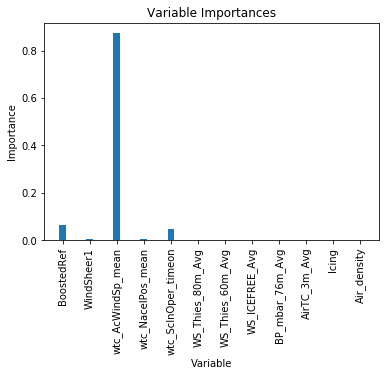

In [148]:
pylab.bar (keepcols, rf.feature_importances_, 1/4)

pylab.xticks(keepcols, rotation='vertical')
pylab.ylabel('Importance'); pylab.xlabel('Variable'); pylab.title('Variable Importances');
pylab.show()

Analyze the results using your chosen method of evaluation. Use
visualizations of the results to bolster the analysis. Explain any visuals and analyze why
they are interesting to someone that might use this model.


# Regression Models: Conclusion

We chose three different regression techniques to predict the power production of a turbine. The three techniques utilized were K Nearest Neighbors regression, Random Forest Regression, and polynomial regression. We evaluated the performance of each model using the R-squared metric. The models and their associated R-squred is listed below.

* **KNN Regression** - R-squared: 0.9274
* **Random Forest** - R-squared: 0.9833
* **Polynomial Regression** - R-squared: 0.99

Using the R-squared metric the best model was the polynomial regression. Although the random-forest had a very similar R-squared. Both models should perform well when deployed in terms of speed. 

# Deployment [5 Points]
These models are very important to the company to find turbines that are underperforming. There are so many factors that affect turbine performance that the analysis is very difficult to do with traditional techniques. The best way to estimate the model value would be to calculate the cost savings of flagging turbines that need to be fixed. There is potentially a lot of money being wasted by not running the assets at their full potential. I would deploy the model as a residual time series after training the model on the first year of operation. This will capture the turbines presitine state and be able to show drifts downward due to gradual blade erosion. A threshold can be set to trigger an alarm after so many points beyond the threshold. The data presented in this report is being collected on a real time basis so no large changes in how data is collected is needed to take this model to production. 

# Exceptional Work [10 Points]
* PCA Analysis for KNN Regression
* Grid Search for KNN Classifier
* Feature importance for KNN classification.
* 6 regression models
* Polynomial version of linear regression with pipeline

# END CASEY'S NOTEBOOK